# emulator GBI algorithm
- train NLE
- load inference & net
- for each theta:
    - emulate N xs
    - compute distances dist(xs,xo)    
    - take average over dist (or some other summary)
    - assign that as p(theta|xo)
    - sample as per usual via MCMC

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pickle
import os
import torch
from torch import Tensor
import numpy as np
import time

# import hydra
# from omegaconf import DictConfig, OmegaConf
# from hydra.utils import get_original_cwd, to_absolute_path

# import logging

# from sbi.inference import MCMCPosterior
# from sbi.utils import mcmc_transform
# from sbi.utils.metrics import c2st as C2ST

# from pathlib import Path

# # Algorithm imports.
# from sbi.inference import SNPE, SNLE, likelihood_estimator_based_potential
from gbi.GBI import GBInference, GBInferenceEmulator
import gbi.utils.utils as gbi_utils

# # Task imports.
from gbi.benchmark.tasks.uniform_1d.task import UniformNoise1D
# from gbi.benchmark.tasks.two_moons.task import TwoMoonsGBI
# from gbi.benchmark.tasks.linear_gaussian.task import LinearGaussian
# from gbi.benchmark.tasks.gaussian_mixture.task import GaussianMixture
from gbi import distances

# import pandas as pd

In [2]:
nle_inference = gbi_utils.pickle_load('../results/benchmark/algorithms/uniform_1d/2023_02_06__19_18_26/NLE/inference.pickle')

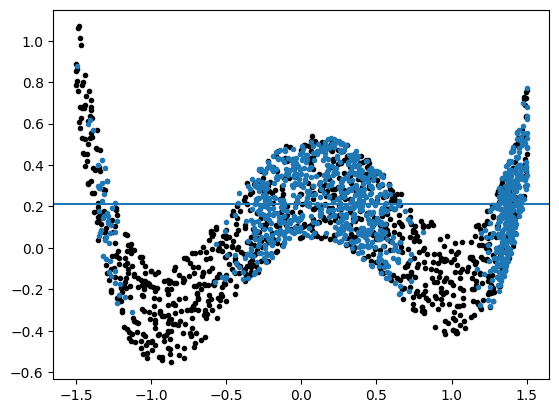

In [23]:
theta,x,c = nle_inference.get_simulations()
xos = gbi_utils.pickle_load('../gbi/benchmark/tasks/uniform_1d/xos/xo_specified_known.pkl')

xo = xos[3]
plt.plot(theta.numpy(), x.numpy().squeeze(), 'k.');
plt.plot(posterior_samples.detach().numpy(), xs, '.')
plt.axhline(xo.numpy())


In [4]:
def sample_eGBI(nle_inference, distance_function, x_o, beta, task, n_samples=10_000, n_emulator_samples=10):
    eGBI = GBInferenceEmulator(emulator_net=nle_inference._neural_net, prior=task.prior, distance_func=distance_function, n_emulator_samples=10)
    potential_fn = eGBI.get_potential(x_o, beta)
    theta_transform = mcmc_transform(task.prior)
    posterior = MCMCPosterior(
        potential_fn,
        theta_transform=theta_transform,
        proposal=task.prior,
        method="slice_np_vectorized",
        thin=10,
        warmup_steps=50,
        num_chains=100,
        init_strategy="resample",
    )
    # Not sure how to fix seed for each chain individually
    posterior_samples = posterior.sample((n_samples,))
    return posterior_samples
    

In [5]:
task = UniformNoise1D()

In [17]:
from sbi.inference import MCMCPosterior
from sbi.utils import mcmc_transform
posterior_samples = sample_eGBI(nle_inference, distances.mse_dist, x_o=xo, beta=100., task=task, n_samples=1000)

Running vectorized MCMC with 100 chains:   0%|          | 0/60000 [00:00<?, ?it/s]

(array([  9.,  34.,   2.,   0.,   0.,   0.,   9.,  37., 101.,  87.,  66.,
        101., 120.,  95.,  26.,   1.,   0.,   4.,  98., 210.]),
 array([-1.49126375, -1.34170079, -1.19213772, -1.04257476, -0.89301169,
        -0.74344873, -0.59388572, -0.44432268, -0.29475969, -0.14519668,
         0.00436634,  0.15392935,  0.30349237,  0.45305535,  0.6026184 ,
         0.75218141,  0.90174437,  1.05130744,  1.20087039,  1.35043347,
         1.49999642]),
 <BarContainer object of 20 artists>)

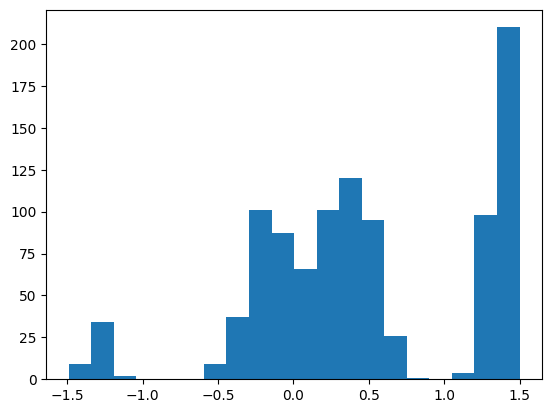

In [18]:
plt.hist(posterior_samples.detach().numpy(), 20)

In [20]:
xs = task.simulate(posterior_samples)

/home/rdgao/miniconda3/envs/gbi/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.asarray(x, float)


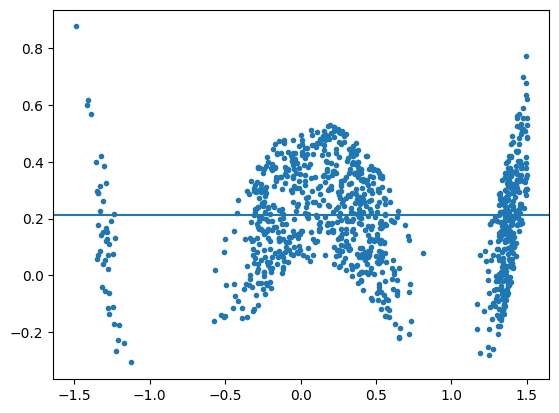

In [22]:
plt.plot(posterior_samples.detach().numpy(), xs, '.')
plt.axhline(xo)

In [14]:
task = UniformNoise1D()
eGBI = GBInferenceEmulator(prior=task.prior,distance_func=distances.mse_dist, emulator_net=nle_inference._neural_net, n_emulator_samples=10)
# GLL = eGBI.build_amortized_GLL(emulator_net=nle_inference._neural_net)
potential_fn = eGBI.get_potential(xo, beta=4.)

In [15]:
from sbi.inference import MCMCPosterior
from sbi.utils import mcmc_transform

theta_transform = mcmc_transform(task.prior)
posterior = MCMCPosterior(
        potential_fn,
        theta_transform=theta_transform,
        proposal=task.prior,
        method="slice_np_vectorized",
        thin=10,
        warmup_steps=50,
        num_chains=100,
        init_strategy="resample",
    )

In [16]:
posterior_samples = posterior.sample((1000,))

Running vectorized MCMC with 100 chains:   0%|          | 0/60000 [00:00<?, ?it/s]

(array([45., 50., 42., 23., 22., 25., 55., 62., 55., 69., 68., 65., 58.,
        56., 70., 37., 21., 41., 67., 69.]),
 array([-1.49926877e+00, -1.34937024e+00, -1.19947171e+00, -1.04957318e+00,
        -8.99674594e-01, -7.49776065e-01, -5.99877536e-01, -4.49978977e-01,
        -3.00080448e-01, -1.50181904e-01, -2.83360481e-04,  1.49615183e-01,
         2.99513727e-01,  4.49412256e-01,  5.99310815e-01,  7.49209344e-01,
         8.99107873e-01,  1.04900646e+00,  1.19890499e+00,  1.34880352e+00,
         1.49870205e+00]),
 <BarContainer object of 20 artists>)

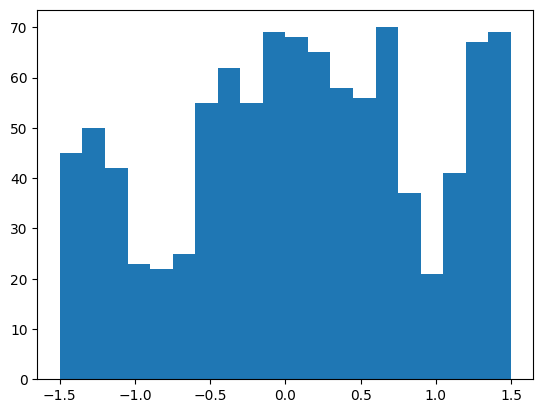

In [17]:
plt.hist(posterior_samples.detach().numpy(), 20)

In [16]:
dist = GLL(theta,xo)

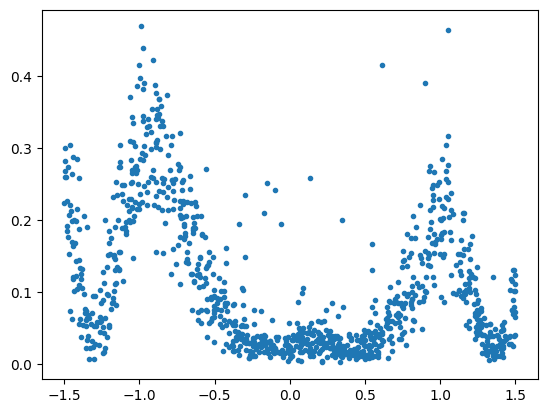

In [17]:
plt.plot(theta.numpy(), dist.detach().numpy(), '.')

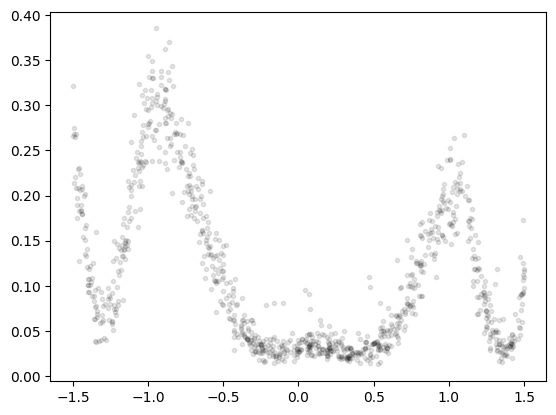

In [126]:
n_emu = 20
with torch.no_grad():
    torch.manual_seed(0)
    x_emu = inference._neural_net.sample(n_emu, theta)

d_emu = distances.mse_dist(x_emu, xos[3])    
plt.plot(theta.numpy(), d_emu.numpy().squeeze(), '.k', alpha=0.1);